In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import pdb

np.random.seed(0)

## Load Data

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'
data_raw = pd.read_csv(data_path)

## Explore Data

In [3]:
data_raw.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


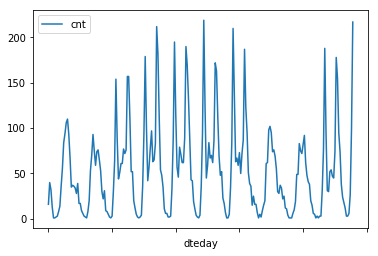

In [4]:
data_raw[:24*10].plot(x='dteday', y='cnt')

## Preprocess Data

Create Dummies

In [5]:
data = data_raw.copy()
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(data[each], prefix=each, drop_first=False)
    data = pd.concat([data, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = data.drop(fields_to_drop, axis=1)

In [6]:
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


Normalize

In [7]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

Split

In [8]:
# Convert to numpy
features = data.drop(['cnt', 'casual', 'registered'], axis=1).values
targets = data['cnt'].values[:,None]

N_t = len(features)
train_x, valid_x, test_x = np.split(features, [int(N_t*0.88815), int(N_t*0.971)])
train_y, valid_y, test_y = np.split(targets, [int(N_t*0.88815), int(N_t*0.971)])

In [9]:
print('train', train_x.shape, train_y.shape)
print('valid', valid_x.shape, valid_y.shape)
print('test', test_x.shape, test_y.shape)

train (15435, 56) (15435, 1)
valid (1440, 56) (1440, 1)
test (504, 56) (504, 1)


## Build Model

In [278]:
def sigmoid(x, deriv=False):
    if deriv:
        return sigmoid(x)*(1-sigmoid(x))
    return 1 / (1 + np.exp(-x))

def tanh(x, deriv=False):
    if deriv:
        return 1. - np.tanh(x)**2
    return np.tanh(x)

def softssign(x, deriv=False):
    if deriv:
        dd = 1 + np.abs(x)
        return (dd - x*np.sign(x)) / dd**2
    return x / (1+np.abs(x))

def relu(x, deriv=False):
    if deriv:
        return 1. * (x>0)
    return np.maximum(0, x)

def lrelu(x, deriv=False):
    if deriv:
        dx = np.ones_like(x)
        dx[x < 0] = 0.01
        return dx
    return np.where(x > 0, x, x * 0.01)

def MSE(y, y_hat):
    # no innner sum, becouse only one output
    return np.mean((y-y_hat)**2)

def fwd(x, W_hid, W_out, act_fun):

    z_hid = x @ W_hid
    h_hid = act_fun(z_hid)  # hidden output

    z_out = h_hid @ W_out
    y_hat = z_out  # linear output

    return y_hat, z_hid, h_hid, z_out

def backprop(x, y, W_hid, W_out, act_fun):
    
    y_hat, z_hid, h_hid, _ = fwd(x, W_hid, W_out, act_fun)
    
    ro_out = (y-y_hat) * -1 # * -act_fun(..), lin out!!
    dW_out = h_hid.T @ ro_out / len(x)
    
    ro_hid = (ro_out @ W_out.T) * act_fun(z_hid, deriv=True)
    dW_hid = x.T @ ro_hid / len(x)
    
    return dW_hid, dW_out
    

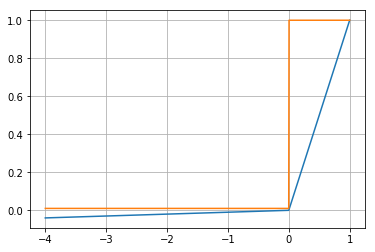

In [279]:
ll = np.linspace(-4, 1, 1000)
plt.plot(ll, lrelu(ll))
plt.plot(ll, lrelu(ll, True))
plt.grid()

## Train Loop - basic

In [19]:
n_in = 56
n_hid = 12
n_out = 1
lr = 0.95
n_batch = 128
iterations = 1500
act_fun = sigmoid

np.random.seed(0)

# Initialize weights
W_hid = np.random.normal(0.0, n_in**-.5, [n_in, n_hid])
W_out = np.random.normal(0.0, n_hid**-.5, [n_hid, n_out])


losses = {'train':[], 'valid':[]}
train_i = np.array(range(len(train_x)))
for i in range(iterations):
    # Get 128 sized batch, both as 2d arrays   
    batch = np.random.choice(train_i, n_batch)
    x = train_x[batch]
    y = train_y[batch]
    
    dW_hid, dW_out = backprop(x, y, W_hid, W_out, act_fun)
        
    W_hid += -lr * dW_hid
    W_out += -lr * dW_out
    
    train_y_hat, _, _, _ = fwd(train_x, W_hid, W_out, act_fun)
    train_loss = MSE(train_y, train_y_hat)
    losses['train'].append(train_loss)
    valid_y_hat, _, _, _ = fwd(valid_x, W_hid, W_out, act_fun)
    valid_loss = MSE(valid_y, valid_y_hat)
    losses['valid'].append(valid_loss)
       
    

(0, 2)

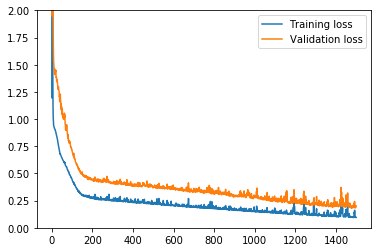

In [12]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['valid'], label='Validation loss')
plt.legend()
plt.ylim(0, 2)

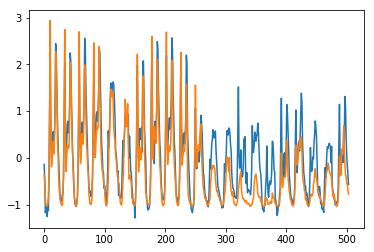

In [22]:
test_y_hat, _, _, _ = fwd(test_x, W_hid, W_out, act_fun)
plt.plot(test_y_hat)
plt.plot(test_y)

In [23]:
W_hid[0:4]

array([[ 0.13977837,  0.39589006, -0.44433984, -0.23372222, -0.32673332,
        -0.31501645,  1.33654143, -0.66407594, -0.532159  , -0.42685932,
         0.27269841, -0.03363818],
       [ 0.48351939, -1.12272939,  0.13089203, -0.06550705,  0.17449842,
        -0.12881516, -0.66353395, -0.07265479, -0.007572  , -0.0190456 ,
        -0.10529271, -0.27215422],
       [ 0.20766098,  0.50374951, -0.47341402, -0.18073073, -0.22643633,
         0.372545  ,  0.16996664, -0.26835636, -1.22899995, -0.3707829 ,
         0.50471608, -0.19382687],
       [ 0.12652124, -0.07856539,  0.03382242, -0.10831552, -0.02563025,
        -0.32419792,  0.00803561,  0.48387678, -0.48559138, -0.17401633,
        -0.32882098,  0.01550563]])

Correct output:
```
array([[ 0.13977837,  0.39589006, -0.44433984, -0.23372222, -0.32673332,
        -0.31501645,  1.33654143, -0.66407594, -0.532159  , -0.42685932,
         0.27269841, -0.03363818],
       [ 0.48351939, -1.12272939,  0.13089203, -0.06550705,  0.17449842,
        -0.12881516, -0.66353395, -0.07265479, -0.007572  , -0.0190456 ,
        -0.10529271, -0.27215422],
       [ 0.20766098,  0.50374951, -0.47341402, -0.18073073, -0.22643633,
         0.372545  ,  0.16996664, -0.26835636, -1.22899995, -0.3707829 ,
         0.50471608, -0.19382687],
       [ 0.12652124, -0.07856539,  0.03382242, -0.10831552, -0.02563025,
        -0.32419792,  0.00803561,  0.48387678, -0.48559138, -0.17401633,
        -0.32882098,  0.01550563]])
```

## Train Loop - with traces

In [332]:
n_in = 56
n_hid = 12 # 12
n_out = 1
lr = 0.55  # 0.55
n_batch = 128
iterations = 1500
act_fun = lrelu

np.random.seed(1)

# Initialize weights
W_hid = np.random.normal(0.0, n_in**-.5, [n_in, n_hid])
W_out = np.random.normal(0.0, n_hid**-.5, [n_hid, n_out])

losses = {'batch':[], 'train':[], 'valid':[]}
traces = {'z_hid':[], 'z_out':[], 'dW_hid':[], 'dW_out':[], 'W_hid':[], 'W_out':[]}

In [323]:
lr = 0.155

In [333]:

train_i = np.array(range(len(train_x)))
for e in range(13):
    np.random.shuffle(train_i)
    for k, v in traces.items():
        v.append([])
    for i in range(0, len(train_x), n_batch):

        # Get 128 sized batch, both as 2d arrays   
        batch = train_i[i:i+n_batch]
        x = train_x[batch]
        y = train_y[batch]

        # Forward pass
        y_hat, z_hid, _, z_out = fwd(x, W_hid, W_out, act_fun)
        batch_loss = MSE(y, y_hat)

        # Calc batch loss (before update!)
        losses['batch'].append(batch_loss)

        # Backpropagation
        dW_hid, dW_out = backprop(x, y, W_hid, W_out, act_fun)
        W_hid += -lr * dW_hid
        W_out += -lr * dW_out

        # Calc full loss, usually only every epoch or so
        train_y_hat, _, _, _ = fwd(train_x, W_hid, W_out, act_fun)
        train_loss = MSE(train_y, train_y_hat)
        losses['train'].append(train_loss)

        valid_y_hat, _, _, _ = fwd(valid_x, W_hid, W_out, act_fun)
        valid_loss = MSE(valid_y, valid_y_hat)
        losses['valid'].append(valid_loss)
        
        # Trace
        traces['z_hid'][-1] += list(z_hid)
        traces['z_out'][-1] += list(z_out)
        traces['dW_hid'][-1].append(dW_hid)
        traces['dW_out'][-1].append(dW_out)
        traces['W_hid'][-1].append(W_hid.copy())
        traces['W_out'][-1].append(W_out.copy())

tr_z_hid = np.array(traces['z_hid'])
tr_z_out = np.array(traces['z_out'])
tr_dW_hid = np.array(traces['dW_hid'])
tr_dW_out = np.array(traces['dW_out'])
tr_W_hid = np.array(traces['W_hid'])
tr_W_out = np.array(traces['W_out'])

print('tr_z_hid', tr_z_hid.shape)
print('tr_z_out', tr_z_out.shape)
print('tr_dW_hid', tr_dW_hid.shape)
print('tr_dW_out', tr_dW_out.shape)
print('tr_W_hid', tr_W_hid.shape)
print('tr_W_out', tr_W_out.shape)

tr_z_hid (13, 15435, 12)
tr_z_out (13, 15435, 1)
tr_dW_hid (13, 121, 56, 12)
tr_dW_out (13, 121, 12, 1)
tr_W_hid (13, 121, 56, 12)
tr_W_out (13, 121, 12, 1)


In [350]:
print('Final train loss:', losses['train'][-1])
print('Final valid loss:', losses['valid'][-1])

Final train loss: 0.06595144070094762
Final valid loss: 0.14175415683385642


# Loss, output

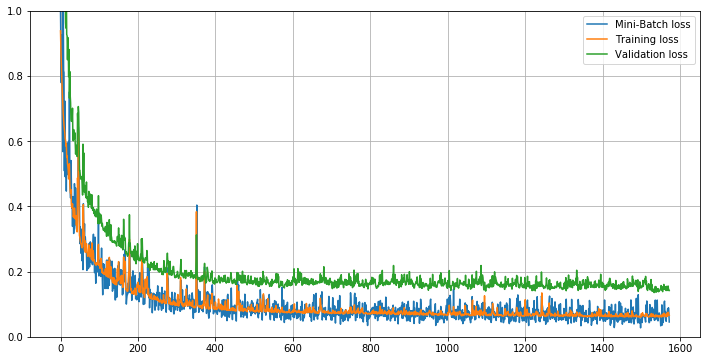

In [334]:
fig, ax = plt.subplots(figsize=[12,6])
ax.plot(losses['batch'], label='Mini-Batch loss')
ax.plot(losses['train'], label='Training loss')
ax.plot(losses['valid'], label='Validation loss')

ax.legend()
ax.set_ylim(0, 1)
ax.grid()

Reference

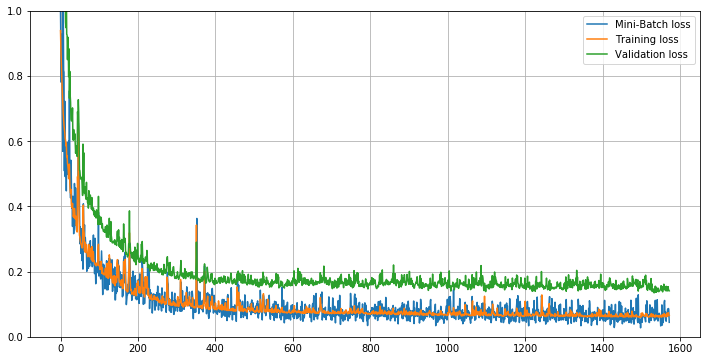

In [283]:
fig, ax = plt.subplots(figsize=[12,6])
ax.plot(losses['batch'], label='Mini-Batch loss')
ax.plot(losses['train'], label='Training loss')
ax.plot(losses['valid'], label='Validation loss')

ax.legend()
ax.set_ylim(0, 1)
ax.grid()

In [345]:
train_x[-100:].shape

(100, 56)

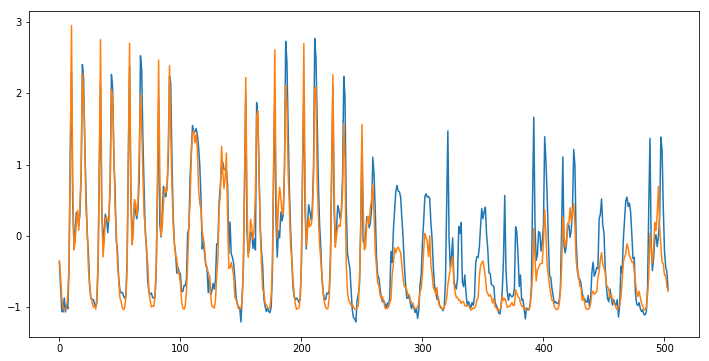

In [336]:
test_y_hat, _, _, _ = fwd(test_x, W_hid, W_out, act_fun)
fig, ax = plt.subplots(figsize=[12,6])
ax.plot(test_y_hat)
ax.plot(test_y)

```
tr_z_hid (13, 15435, 12)
tr_z_out (13, 15435, 1)
tr_dW_hid (13, 121, 56, 12)
tr_dW_out (13, 121, 12, 1)
tr_W_hid (13, 121, 56, 12)
tr_W_out (13, 121, 12, 1)
```

In [407]:
ne, na, nn = tr_z_hid.shape

In [408]:
tmp_hid = act_fun(tr_z_hid)  # (13, 15435, 12)
tmp_hid.shape

(13, 15435, 12)

In [ ]:



activ_hid = activ_hid.reshape([ne*na, nn])
#activ_hid_means = np.mean(activ_hid, axis=1)

activ_hid.shape

In [383]:
15435 / 155

99.58064516129032

In [394]:
ne, na, nn


(200655, 12)

In [402]:
activ_hid = np.array( np.split(activ_hid[:200000], 200) ) # (200, 1000, 12)

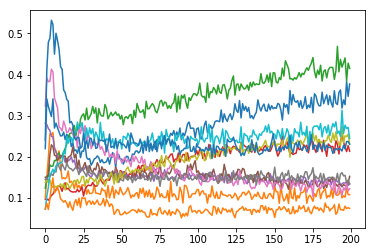

In [405]:
plt.plot(np.mean(activ_hid, axis=1))

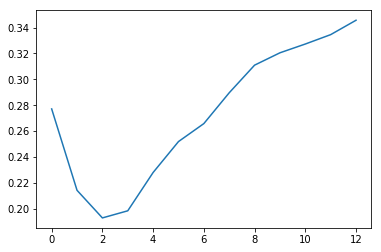

In [376]:
plt.plot(activ_hid_means[:,0])

# Weight Plots

In [230]:
def running_mean(x, n):
    return np.array([ np.mean(x[max(i-n+1, 0): i+1]) for i in range(len(x))])

In [231]:
def running_std(x, n):
    return np.array([ np.std(x[max(i-n+1, 0): i+1]) for i in range(len(x))])

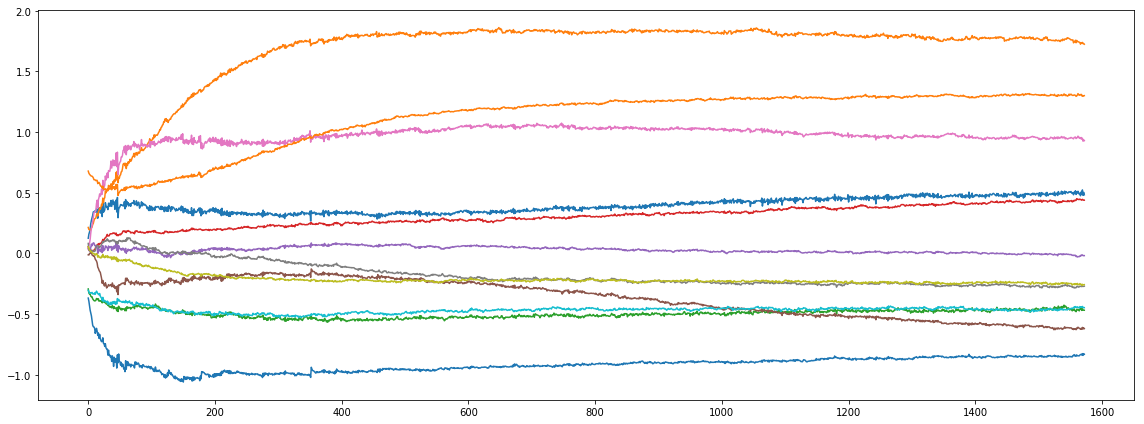

In [352]:
ne, ni, nw, nn = tr_W_out.shape

fig = plt.figure(figsize=[16,6])
ax = fig.add_subplot(111)


ax.plot(tr_W_out.reshape([-1,nw, nn])[:,:,0])
plt.tight_layout()
plt.show()
del ne, ni, nw, nn

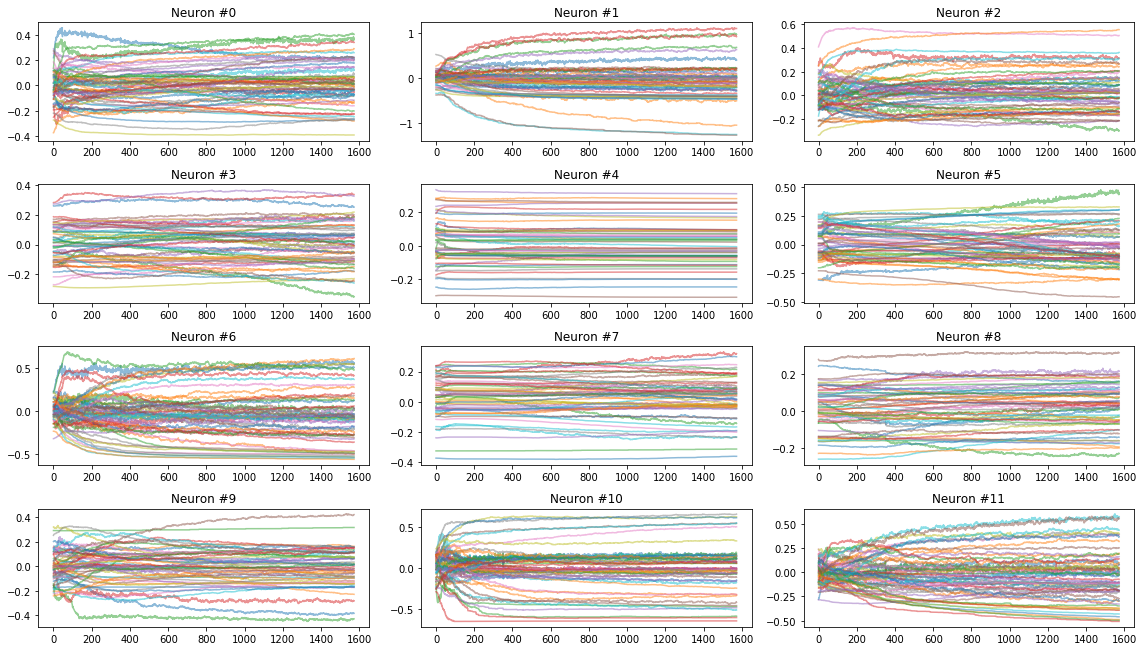

In [365]:
fig = plt.figure(figsize=[16,180])

for i in range(nn):
    ax = fig.add_subplot(80,3,i+1)
    tmp = np.reshape(tr_W_hid, (ne*ni, nw, nn))
    ax.plot(tmp[:,:,i], alpha=0.5)
    ax.set_title('Neuron #'+str(i))
plt.tight_layout()
plt.show()


# Activation Histograms

In [367]:
def plot_3d_histogram(data, funct=lambda x: x, color=(1,0,0,1), alpha=1, ax=None, figsize=None):
    """
    
    Params:
        data - 2d array, dims: [epochs, samples].
               E.g. for single neuron activations: [[ 0.1, 0.2, 0.3, ... ]  activations in epoch 0, sample 1, 2, 3...
                                                    [ 0.2, 0.1, 0.3, ... ]  activations in epoch 1, ...
                                                    ...
                                                    [ 0.3, 0.1, 0.2, ... ]] activations is last training epoch
        funct - function to apply to data before plotting, e.g. sigmoid, tanh, usually none
    """
    assert data.ndim==2
    color = np.array(color)
    
    def interpolate_colors(cstart, cend, n):
        cstart, cend = np.array(cstart), np.array(cend)
        assert cstart.shape == (4,)
        assert cend.shape == (4,)
        if n == 1:  return cend    # if one step, then return end color

        cols = []
        for i in range(n):
            step = i/(n-1)
            cols.append( (1-step)*cstart + step*cend)
        return np.array(cols)
    
    color_start = np.array(color/len(data), dtype=float)  # transparent black
    color_end = np.array(color)
    colors = interpolate_colors(color_start, color_end, len(data))
    

    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d')
    
    ax.set_xlabel('value'); ax.set_ylabel('epoch'); ax.set_zlabel('n')
    ax.view_init(30, -85)
    # ax.set_xlim(0, 1)
    
    for epoch in range(len(data)):                                     # One line per epoch
        hist, bins = np.histogram(funct(data[epoch,:]), bins=100)      # apply funct and create histogram
        bins = (bins[:-1] + bins[1:])/2                                # center bins
        hist = hist / np.sum(hist)
        ax.plot(xs=bins, ys=hist,
                zs=-epoch,
                zdir='y', 
                color=colors[epoch])
        if epoch == 0:
            nb_epochs = len(data)
            ax.plot(xs=[-1,-1], ys=[0,0], zs=[-nb_epochs,0], zdir='y', color='k', ls='--')
            ax.plot(xs=[0,0], ys=[0,0], zs=[-nb_epochs,0], zdir='y', color='k')
            ax.plot(xs=[1,1], ys=[0,0], zs=[-nb_epochs,0], zdir='y', color='k', ls='--')
        if epoch == len(data)-1:
            ax.plot(xs=[bins[0],bins[-1]], ys=[0,0], zs=-nb_epochs, zdir='y', color='k')

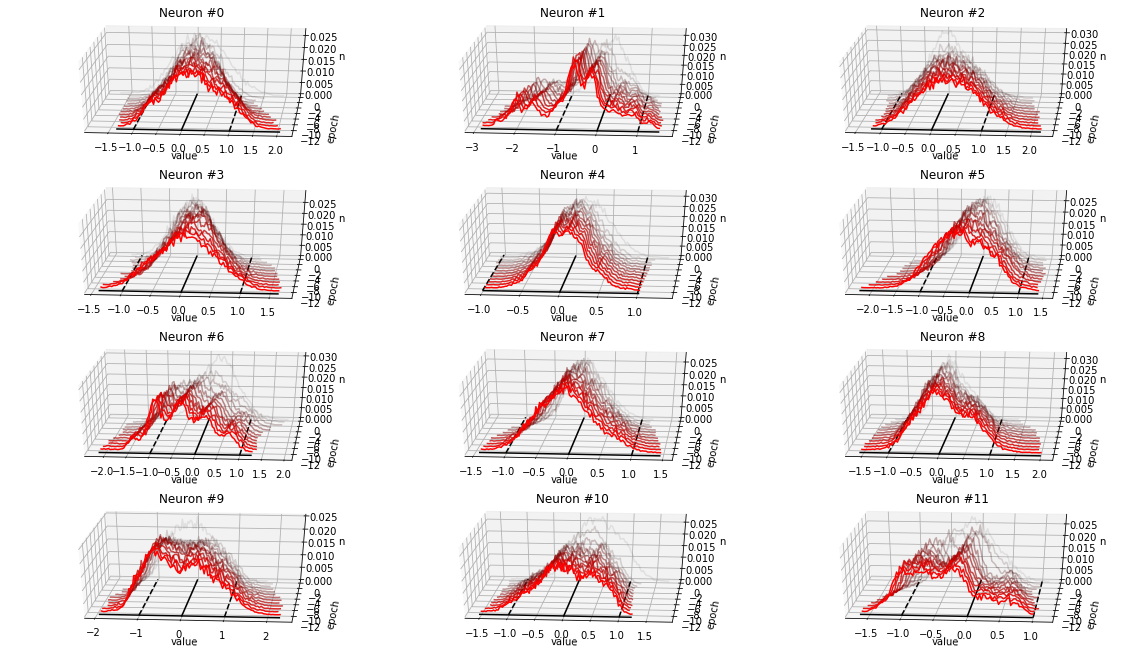

In [370]:
fig = plt.figure(figsize=[16,180])

for n in range(tr_z_hid.shape[-1]):
    ax = fig.add_subplot(80, 3, n+1, projection='3d')
    plot_3d_histogram(tr_z_hid[::,:,n], funct=lambda x: x, ax=ax)
    ax.set_title('Neuron #' + str(n))

plt.tight_layout()
plt.show()

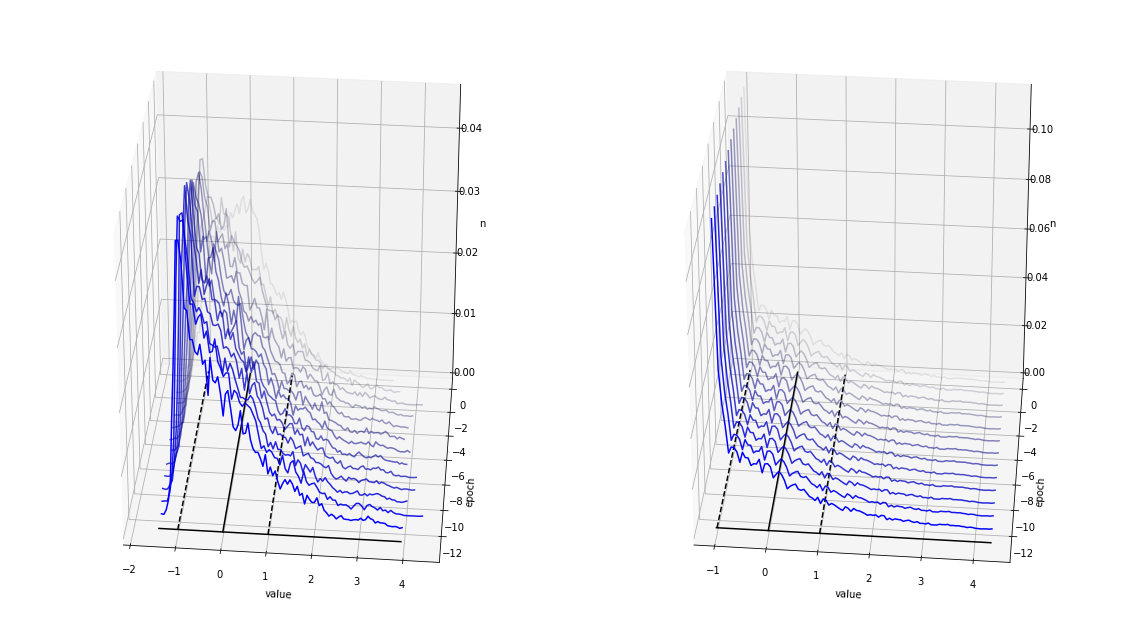

In [369]:
fig = plt.figure(figsize=[16,9])
ax = fig.add_subplot(121, projection='3d')
plot_3d_histogram(tr_z_out[:,:,0], color=(0,0,1,1), ax=ax)
ax = fig.add_subplot(122, projection='3d')
plot_3d_histogram(np.repeat(train_y.T, 13, axis=0), color=(0,0,1,1), ax=ax)
plt.tight_layout()
plt.show();

# Other

relat_out (4718, 12, 1)


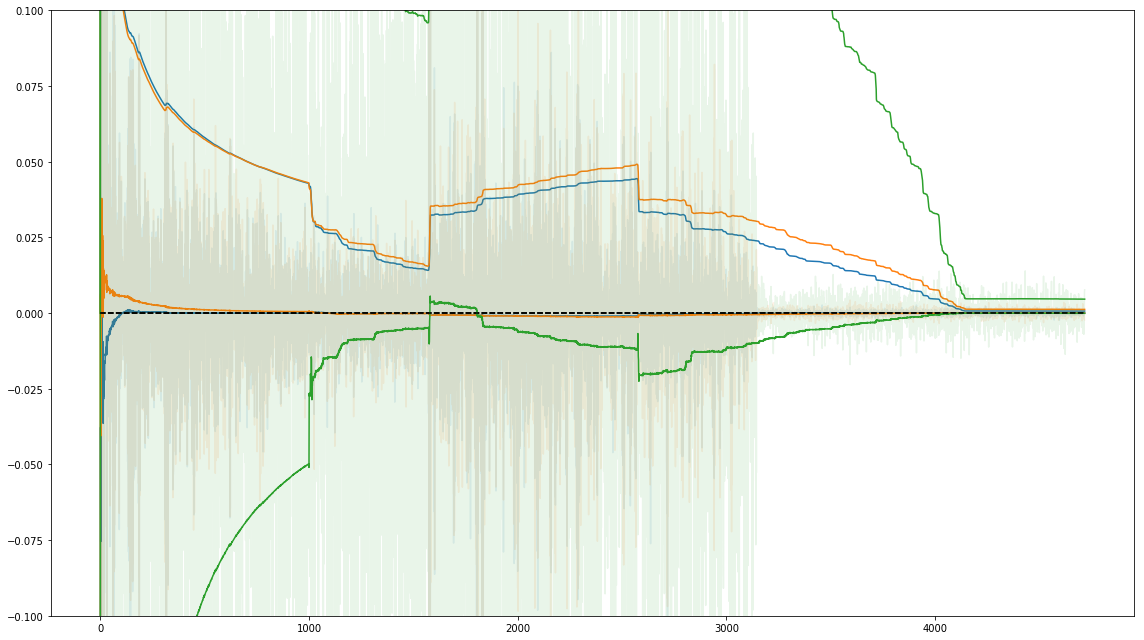

In [459]:
aa_W_out = tr_W_out.reshape([-1,12,1])[1:]
bb_W_out = tr_W_out.reshape([-1,12,1])[:-1]
#print('aa_W_out', aa_W_out.shape)
#print('bb_W_out', bb_W_out.shape)
diff_W_out = aa_W_out - bb_W_out
#print('diff_W_out', diff_W_out.shape)
relat_out = diff_W_out / aa_W_out
print('relat_out', relat_out.shape)

fig = plt.figure(figsize=[16,9])
ax = fig.add_subplot(111)

for i in range(3): #relat_out.shape[1]):
    to_plot = relat_out[:,i:i+1,0]
    #print('to_plot', to_plot.shape)
    
    
    line = ax.plot(to_plot, alpha=0.1)[0]
    ax.plot(running_mean(to_plot, n=1000), color=line.get_color());
    ax.plot(running_std(to_plot, n=1000), color=line.get_color());
    ax.plot([0,len(to_plot)],[0.0, 0.0], linestyle='--', color='k')
    #ax.plot([0,900],[0.01, 0.01], linestyle='--')
    # ax.ylim(0, 0.2)
    # ax.set_yscale('log')
    ax.set_ylim([-.1,0.1])
plt.tight_layout()
plt.show()

In [362]:
tr_W_out.shape

(39, 121, 12, 1)

aa_W_out (26, 120, 12, 1)
bb_W_out (26, 120, 12, 1)
diff_W_out (26, 120, 12, 1)
relat_out (26, 120, 12, 1)
out_weight (26, 120)


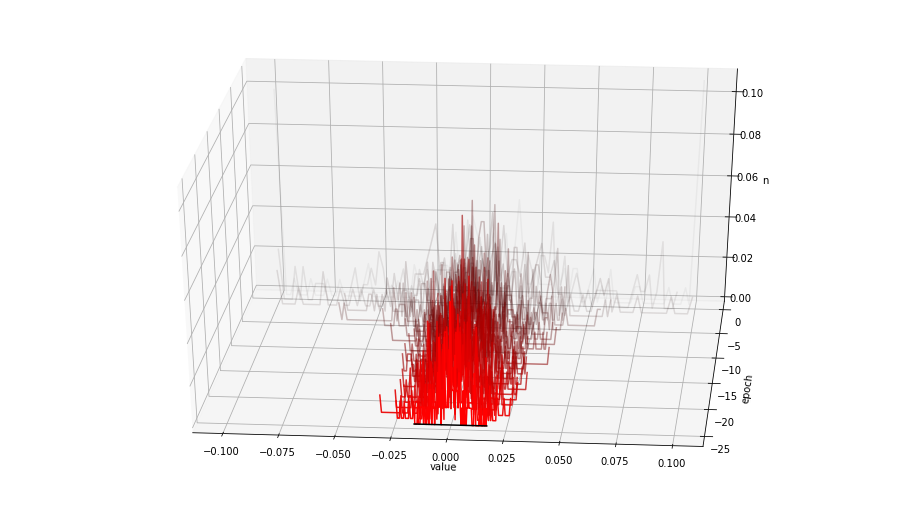

In [543]:
aa_W_out = tr_W_out[:,1:,:,:]
bb_W_out = tr_W_out[:,:-1,:,:]
print('aa_W_out', aa_W_out.shape)
print('bb_W_out', bb_W_out.shape)
diff_W_out = aa_W_out - bb_W_out
print('diff_W_out', diff_W_out.shape)
relat_out = diff_W_out / aa_W_out
print('relat_out', relat_out.shape)

out_weight = relat_out[:,:,0,0]
print('out_weight', out_weight.shape)

plot_3d_histogram(np.clip(out_weight, -0.1, 0.1), figsize=[16,9])

aa_W_out (4718, 12, 1)
bb_W_out (4718, 12, 1)
diff_W_out (4718, 12, 1)
relat_out (4718, 12, 1)


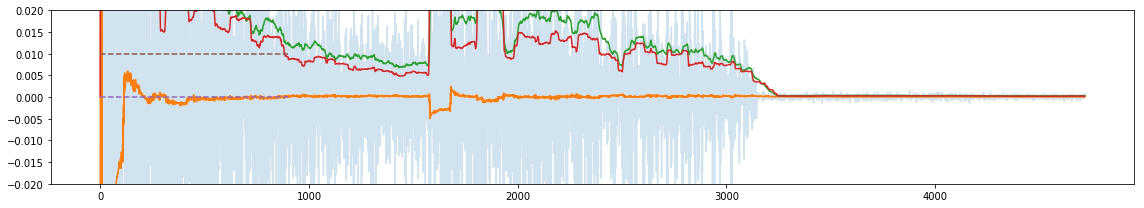

In [419]:
aa_W_out = tr_W_out.reshape([-1,12,1])[1:]
bb_W_out = tr_W_out.reshape([-1,12,1])[:-1]
print('aa_W_out', aa_W_out.shape)
print('bb_W_out', bb_W_out.shape)
diff_W_out = aa_W_out - bb_W_out
print('diff_W_out', diff_W_out.shape)
relat_out = diff_W_out / aa_W_out
print('relat_out', relat_out.shape)  
to_plot = relat_out[:,-1:,0]
#print('to_plot', to_plot.shape)
fig = plt.figure(figsize=[16,3])
ax = fig.add_subplot(111)
ax.plot(to_plot, alpha=0.2);
ax.plot(running_mean(to_plot, n=100));
ax.plot(running_mean(np.abs(to_plot), n=100));
ax.plot(running_std(np.abs(to_plot), n=100));
ax.plot([0,900],[0.0, 0.0], linestyle='--')
ax.plot([0,900],[0.01, 0.01], linestyle='--')
# ax.ylim(0, 0.2)
# ax.set_yscale('log')
ax.set_ylim([-.02,0.02])
plt.tight_layout()
plt.show()

In [167]:
def get_ratios(weights):
    assert weights.ndim==3
    
    aa_W = weights.reshape([-1,12,1])[1:]
    bb_W = weights.reshape([-1,12,1])[:-1]
    diff_W = bb_W - aa_W
    relat = diff_W / aa_W
    
    assert relat.ndim == 3
    return relat

to_plot (1000, 12)


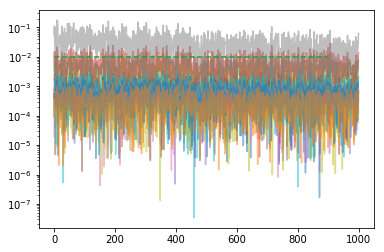

In [168]:
ratios = get_ratios(tr_W_out.reshape([-1,12,1]))
to_plot = ratios[-1000:,:,0]

print('to_plot', to_plot.shape)
plt.plot(np.abs(to_plot), alpha=0.5);
#plt.plot(running_mean(np.abs(to_plot), n=100)[100:]);
plt.plot([0,900],[0.01, 0.01], linestyle='--')
# plt.ylim(0, 0.2)
plt.yscale('log')
    
    


aa_W_out (6292, 12, 1)
bb_dW_out (6292, 12, 1)
relat_out (6292, 12, 1)
to_plot (1000, 12)


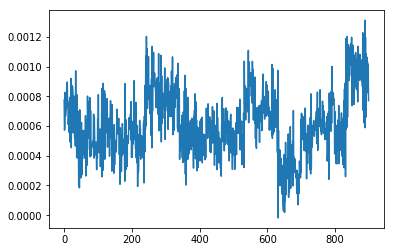

In [557]:
aa_W_out = tr_W_out.reshape([-1,12,1])
bb_dW_out = tr_dW_out.reshape([-1,12,1])
print('aa_W_out', aa_W_out.shape)
print('bb_dW_out', bb_dW_out.shape)
relat_out = (bb_dW_out / aa_W_out)
print('relat_out', relat_out.shape)
to_plot = relat_out[-1000:,:,0]
print('to_plot', to_plot.shape)

plt.plot(running_mean(lr*to_plot, n=100)[100:]);


#plt.plot(running_mean(bb_dW_out / aa_W_out, n=100)[-1000:,:,0], alpha=1)
# plt.ylim(0, 0.2)
#plt.yscale('log')

In [67]:
bb_dW_out.shape

(4719, 12, 1)

# Weights

In [171]:
tr_z_hid.shape

(39, 15435, 12)

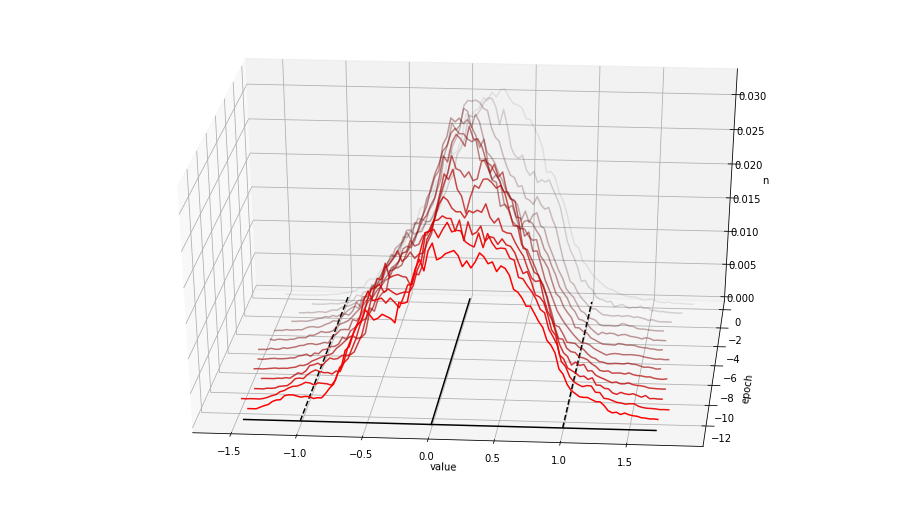

In [319]:
fig = plt.figure(figsize=[16,9])
ax = fig.add_subplot(111, projection='3d')

dd = tr_z_hid.reshape([tr_z_hid.shape[0],-1])
#plot_3d_histogram(dd, funct=lambda x: sigmoid(x), color=(0,0,1,.1), ax=ax)
plot_3d_histogram(dd, funct=lambda x: x, ax=ax)

Zoom in one neuron

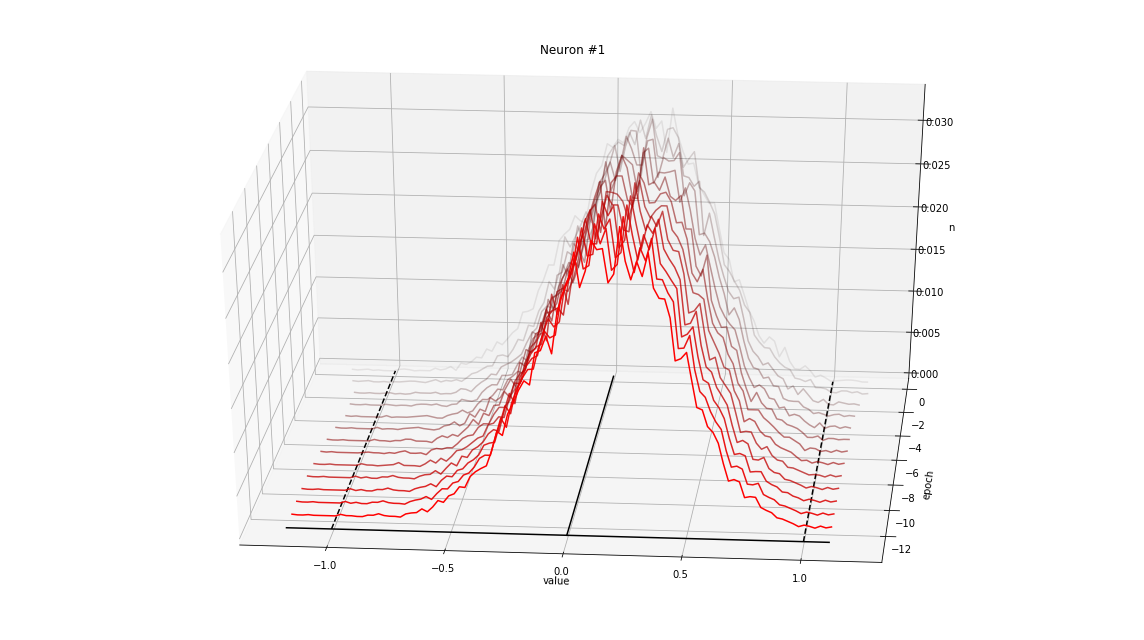

In [308]:
fig = plt.figure(figsize=[16,9])

ax = fig.add_subplot(111, projection='3d')
plot_3d_histogram(tr_z_hid[:,:,1], funct=lambda x: x, ax=ax)
ax.set_title('Neuron #1')
#ax.set_xscale('log')

plt.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize=[16,18])

for n in range(tr_z_hid.shape[-1]):
    ax = fig.add_subplot(8, 3, n+1, projection='3d')
    plot_3d_histogram(tr_z_hid[:,:,n], funct=lambda x: x, ax=ax)
    ax.set_title('Neuron #' + str(n))

plt.tight_layout()
plt.show()

In [258]:
ne, na, nn = tr_z_hid.shape
tmp = tr_z_hid.reshape([-1,nn])
print(tmp.shape)

(401310, 12)


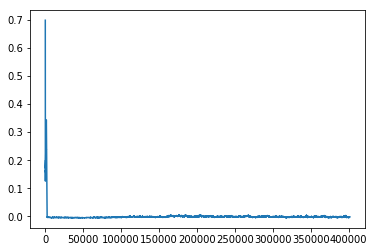

In [288]:
plt.plot(running_mean(act_fun(tmp[:,0]), n=1000))
#plt.yscale('log')

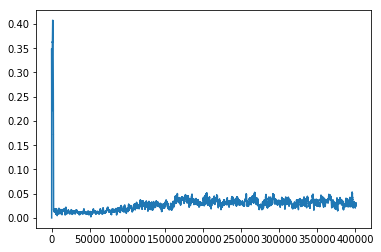

In [253]:
plt.plot(running_std(act_fun(tmp[:,0]), n=1000))
#plt.yscale('log')

In [234]:
tr_z_hid.shape

(26, 15435, 12)

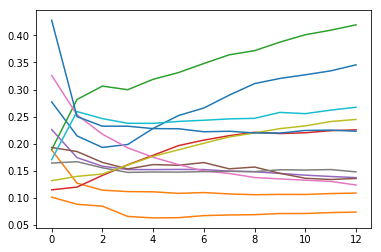

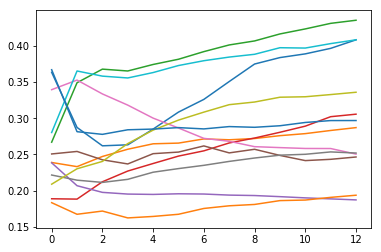

In [289]:
#fig = plt.figure(figsize=[16,18])
#ax = fig.add_subplot(111)


#plt.tight_layout()
#plt.show()

ne, na, nn = tr_z_hid.shape
plt.plot(np.mean(act_fun(tr_z_hid), axis=1))
plt.show()
plt.plot(np.std(act_fun(tr_z_hid), axis=1))
plt.show()

In [190]:
tr_z_hid.shape

(26, 15435, 12)